## Our Fire Dataset Analysis Approach

The complete dataset can be downloaded as :
=====================================================================
import kagglehub

#Download latest version

path = kagglehub.dataset_download("brsdincer/leo-satellite-global-fire-data-1-year-nasa")
print("Path to dataset files:", path)
=====================================================================
It is almost 1GB dataset size, so, we downloaded a sample dataset modis_2010_Turkey.csv to analysis meta data of the Fire Dataset. This is the fire dataset for Turkey

## Detail Classification Approach
This dataset is derived from NASA’s VIIRS and MODIS sensors, which detect thermal anomalies (fires, volcanoes, static heat sources) globally. The dataset includes information on: <br>

Latitude & Longitude: The center of the detected thermal anomaly. <br>
Brightness Temperature (Kelvin): Indicates the temperature of the detected fire pixel. <br>
Fire Radiative Power (FRP, MW): Represents the intensity of the detected fire. <br>
Acquisition Date & Time: When the fire was detected by the satellite. <br>
Satellite & Instrument: Identifies which satellite (Terra/Aqua for MODIS, Suomi NPP/NOAA-20 for VIIRS) and instrument (MODIS or VIIRS) collected the data. <br>
Scan & Track: Indicates the pixel size and resolution of the detection. <br>
Confidence (Low/Nominal/High): Represents the certainty that the detected hotspot is a true fire. <br>
Day/Night Classification: Indicates whether the fire was detected in daylight (D) or nighttime (N). <br>
Type of Fire Source: <br>
0 = Presumed vegetation fire (wildfire) <br>
1 = Active volcano <br>
2 = Other static land source <br>
3 = Offshore fire (industrial, oil rigs, etc.) <br>

## Potential Classes
As we are focusing on wildfires, the classes can be defined as: <br>

1. 0D (Vegetation Fire - Daytime) → Wildfire
2. 0N (Vegetation Fire - Nighttime) → Wildfire
3. 1D (Volcanic Activity - Daytime) → Non-Wildfire
4. 1N (Volcanic Activity - Nighttime) → Non-Wildfire
5. 2D (Static Land Source - Daytime) → Non-Wildfire
6. 2N (Static Land Source - Nighttime) → Non-Wildfire
7. 3D (Offshore Fire - Daytime) → Non-Wildfire
8. 3N (Offshore Fire - Nighttime) → Non-Wildfire

Since wildfires are typically represented by 0D and 0N, a typical classification algorithm label data as: <br>
Train a classification model that labels data as <b>"Wildfire" (0D, 0N)</b> vs. <b>"Non-Wildfire" (all others).</b>

### Libaries installed (just for reference)
!pip install geopandas  
!pip install geodatasets

In [1]:
import pandas as pd

# Load dataset (modify path accordingly)
data_path = "data/modis_2010_Turkey.csv"
df = pd.read_csv(data_path)

# General dataset information
print(df.info())

# Display first 5 rows
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13653 entries, 0 to 13652
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    13653 non-null  float64
 1   longitude   13653 non-null  float64
 2   brightness  13653 non-null  float64
 3   scan        13653 non-null  float64
 4   track       13653 non-null  float64
 5   acq_date    13653 non-null  object 
 6   acq_time    13653 non-null  int64  
 7   satellite   13653 non-null  object 
 8   instrument  13653 non-null  object 
 9   confidence  13653 non-null  int64  
 10  version     13653 non-null  float64
 11  bright_t31  13653 non-null  float64
 12  frp         13653 non-null  float64
 13  daynight    13653 non-null  object 
 14  type        13653 non-null  int64  
dtypes: float64(8), int64(3), object(4)
memory usage: 1.6+ MB
None
   latitude  longitude  brightness  scan  track    acq_date  acq_time  \
0   39.1908    31.1941       307.8   1.6    1.2  2010-

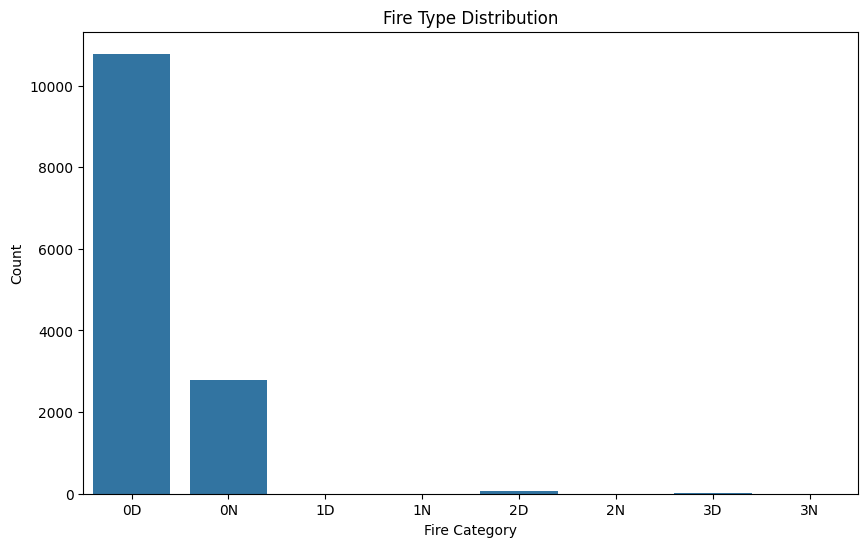

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a new column for classification
df['fire_category'] = df['type'].astype(str) + df['daynight']

# Countplot of different fire types
plt.figure(figsize=(10,6))
sns.countplot(x='fire_category', data=df, order=['0D', '0N', '1D', '1N', '2D', '2N', '3D', '3N'])
plt.title('Fire Type Distribution')
plt.xlabel('Fire Category')
plt.ylabel('Count')
plt.show()

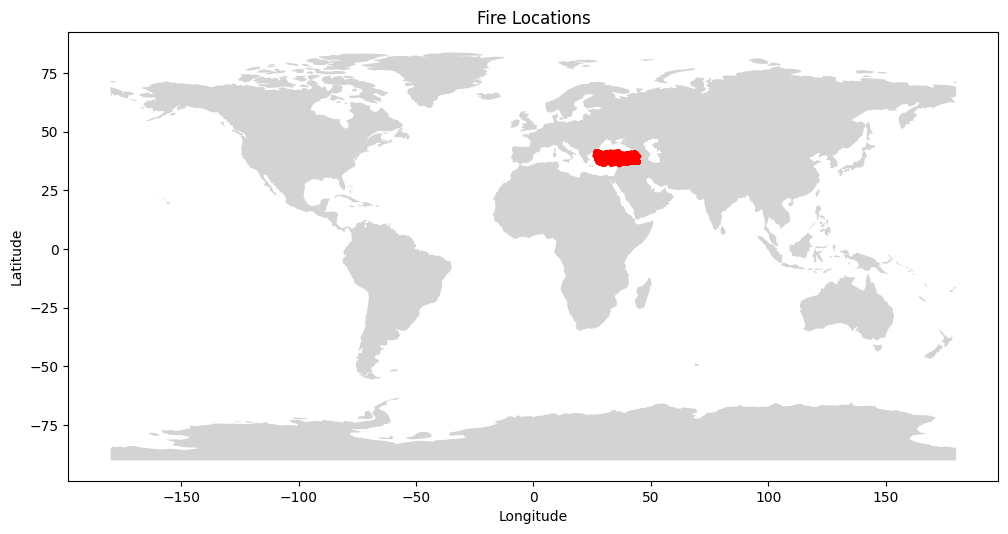

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geodatasets  # New package to get datasets

# Convert latitude and longitude to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Load the world map using geodatasets
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# Plot the map
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color='lightgrey')

# Plot fire locations
gdf.plot(ax=ax, markersize=5, color='red', alpha=0.5)
plt.title('Fire Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


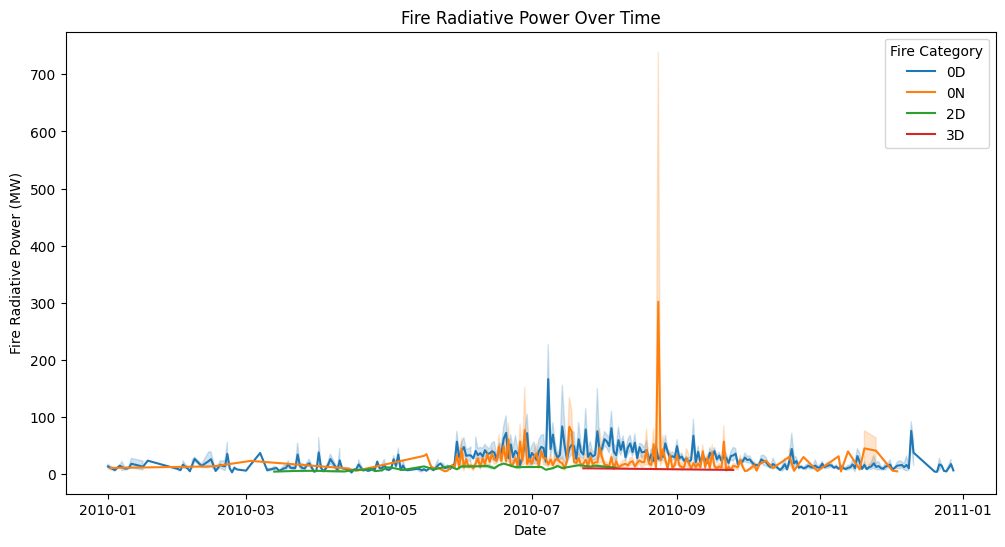

In [8]:
df['acq_date'] = pd.to_datetime(df['acq_date'])

plt.figure(figsize=(12,6))
sns.lineplot(x='acq_date', y='frp', data=df, hue='fire_category')
plt.title('Fire Radiative Power Over Time')
plt.xlabel('Date')
plt.ylabel('Fire Radiative Power (MW)')
plt.legend(title='Fire Category')
plt.show()

## Feature Engineering of Fire Dataset

1. Brightness Differences (brightness_diff): Helps differentiate between fire intensity levels.
2. Log Transformed FRP (log_frp): Reduces skewness in fire power values.
3. Scan-to-Track Ratio (scan_track_ratio): Estimates pixel footprint variation.
4. Confidence Encoding (confidence): Converts textual confidence into numerical values.
5. Fire Category (fire_category): Encodes type and day/night into a single categorical variable.


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load dataset
df = pd.read_csv("data/modis_2010_Turkey.csv")  # Replace with your dataset file

# Convert date column to datetime format
df["acq_date"] = pd.to_datetime(df["acq_date"])

# Feature 1: Brightness Temperature Differences
df["brightness_diff"] = df["brightness"] - df["bright_t31"]

# Feature 2: Fire Radiative Power (FRP)
df["log_frp"] = np.log1p(df["frp"])  # Log transform for normalization

# Feature 3: Scan-Track Ratio (Pixel Size Indicator)
df["scan_track_ratio"] = df["scan"] / df["track"]

# Feature 4: Encode Confidence Levels
confidence_mapping = {"low": 0, "nominal": 1, "high": 2}
df["confidence"] = df["confidence"].replace(confidence_mapping)

# Feature 5: Type & Day/Night Encoding
df["fire_category"] = df["type"].astype(str) + df["daynight"]
df["fire_category"] = LabelEncoder().fit_transform(df["fire_category"])

# Selecting final features for classification
features = [
    "brightness", "bright_t31", "brightness_diff", 
    "log_frp", "scan", "track", "scan_track_ratio", 
    "confidence", "fire_category"
]

X = df[features]
y = df["type"]  # Target variable for classification

# Standardizing numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Display sample processed data
print("Scaled Data:")
print(X_scaled_df.head())


Scaled Data:
   brightness  bright_t31  brightness_diff   log_frp      scan     track  \
0   -1.028797   -1.635486         0.127905 -0.034270  0.102126  0.070660   
1    0.058326   -1.161608         1.332903  0.387758 -0.570680 -0.792624   
2   -1.286104   -1.379592        -0.550540 -1.007063 -0.436119 -0.360982   
3   -1.498383   -1.360637        -0.904951 -1.395688 -0.436119 -0.360982   
4   -0.777922   -1.483845         0.360804 -0.380943 -0.570680 -0.792624   

   scan_track_ratio  confidence  fire_category  
0          0.345082   -0.062191      -0.506218  
1         -0.445279    0.845135      -0.506218  
2         -0.476072   -0.542541      -0.506218  
3         -0.476072   -1.609983      -0.506218  
4         -0.445279    0.258042      -0.506218  


## Data Preprocessing

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load dataset
df = pd.read_csv("data/modis_2010_Turkey.csv")  # Change file name if needed

# Convert DayNight to binary: D -> 0, N -> 1
df['daynight'] = df['daynight'].map({'D': 0, 'N': 1})

# Create Wildfire vs Non-Wildfire labels
df['wildfire'] = ((df['type'] == 0) & (df['daynight'].isin([0, 1]))).astype(int)  # 1 = Wildfire, 0 = Non-Wildfire

# Drop unnecessary columns (latitude, longitude, date, time, etc.)
features = ['brightness', 'scan', 'track', 'confidence', 'bright_t31', 'frp']
X = df[features]
y = df['wildfire']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Data processing complete. Ready for training.")


Data processing complete. Ready for training.


## Random Forest Classifier (RFC)
<b>Reason for choosing RFC</b> <br>
1. Handles structured data efficiently.
2. Works well with missing or noisy data.
3. Feature importance can be analyzed.
4. Computationally efficient compared to deep learning.

<b>Training Cost </b> <br>
Medium – Can be parallelized, but many trees increase computation. <br>

<b>Expected Accuracy</b> <br>
85-90% if features are informative

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9937751739289638
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.99      1.00      1.00      2714

    accuracy                           0.99      2731
   macro avg       0.50      0.50      0.50      2731
weighted avg       0.99      0.99      0.99      2731



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

## Support Vector Machine (SVM)
<b>Reason for choosing SVM</b> <br>
1. Good for smaller datasets.
2. Works well in high-dimensional spaces.
3. Handles class imbalance well with kernels.

<b>Training Cost </b> <br>
High – Slower for large datasets. <br>

<b>Expected Accuracy</b> <br>
80-88% – Performs well with well-separated features.

In [17]:
from sklearn.svm import SVC

# Train SVM Classifier
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

# Predict
y_pred_svm = svm_model.predict(X_test)

# Evaluate
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.9937751739289638
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.99      1.00      1.00      2714

    accuracy                           0.99      2731
   macro avg       0.50      0.50      0.50      2731
weighted avg       0.99      0.99      0.99      2731



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

## Multi Layer Perceptron (MLP)
<b>Reason for choosing MLP</b> <br>
1. Learns complex patterns in data.
2. Can handle non-linearity better than classical ML models.
3. Suitable for structured tabular data when CNNs aren’t applicable.

<b>Training Cost </b> <br>
High – Requires GPU for larger datasets. <br>

<b>Expected Accuracy</b> <br>
85-92% – If hyperparameters are well-tuned.

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define MLP Model
mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
mlp_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate
loss, acc = mlp_model.evaluate(X_test, y_test)
print("MLP Accuracy:", acc)


Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 617us/step - accuracy: 0.9833 - loss: 0.1736 - val_accuracy: 0.9938 - val_loss: 0.0320
Epoch 2/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.9948 - loss: 0.0300 - val_accuracy: 0.9938 - val_loss: 0.0297
Epoch 3/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.9937 - loss: 0.0330 - val_accuracy: 0.9938 - val_loss: 0.0298
Epoch 4/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.9953 - loss: 0.0267 - val_accuracy: 0.9938 - val_loss: 0.0294
Epoch 5/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.9938 - loss: 0.0323 - val_accuracy: 0.9938 - val_loss: 0.0299
Epoch 6/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.9942 - loss: 0.0289 - val_accuracy: 0.9938 - val_loss: 0.0298
Epoch 7/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.9943 - loss: 0.0283 - val_accuracy: 0.9938 - val_loss: 0.0295
Epoch 8/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 0.9942 - loss: 0.0304 - val_accurac

## MLP  (Pytorch)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

# Define the PyTorch MLP Model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()  # Binary classification output

    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))
        return x

# Model Initialization
input_size = X_train.shape[1]  # Number of features
model = MLP(input_size)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001) #Adam Classifier with LR=0.001

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
#y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape for BCELoss
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)


X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
#y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)
# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training Loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete.")

# Evaluation Mode
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        predictions = (outputs >= 0.5).float()  # Convert probabilities to 0 or 1

        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Compute Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"MLP Model Accuracy: {accuracy * 100:.2f}%")


Epoch [1/20], Loss: 0.0899
Epoch [2/20], Loss: 0.0322
Epoch [3/20], Loss: 0.0310
Epoch [4/20], Loss: 0.0307
Epoch [5/20], Loss: 0.0308
Epoch [6/20], Loss: 0.0309
Epoch [7/20], Loss: 0.0304
Epoch [8/20], Loss: 0.0308
Epoch [9/20], Loss: 0.0305
Epoch [10/20], Loss: 0.0303
Epoch [11/20], Loss: 0.0301
Epoch [12/20], Loss: 0.0304
Epoch [13/20], Loss: 0.0299
Epoch [14/20], Loss: 0.0295
Epoch [15/20], Loss: 0.0301
Epoch [16/20], Loss: 0.0299
Epoch [17/20], Loss: 0.0305
Epoch [18/20], Loss: 0.0302
Epoch [19/20], Loss: 0.0299
Epoch [20/20], Loss: 0.0294
Training complete.
MLP Model Accuracy: 99.38%


## Applying Federated Learning for Wildfire Classification
<b>Introduction</b> <br>
<p>Wildfire classification using satellite data is crucial for early detection and mitigation. However, due to privacy concerns and country-specific geospatial sensitivities, centralizing this data for training is not feasible. Federated Learning (FL) offers a decentralized approach where multiple clients (countries) train models locally and share only model parameters with a central server for aggregation. This ensures data privacy while benefiting from collaborative learning.</p><br>

<b>Federated Learning Setup for Wildfire Classification</b>
1. <b>Clients (Countries):</b> <br>
   Each country deploys a different model: <br>
        <b>Client 1</b>: Random Forest Classifier (RFC) <br>
        <b>Client 2</b>: Support Vector Machine (SVM) <br>
        <b>Client 3</b>: Multi-Layer Perceptron (MLP) <br>
    Each client trains its model locally using country-specific wildfire satellite data. <br>
    The models learn from brightness temperature, fire radiative power (FRP), confidence, scan size, and type+day/night information. <br>
2. <b>Federated Server</b> <br>
   The server collects updated model parameters from all clients. <br>
   It aggregates the parameters using Multi-Heterogeneous Aggregated Training (MHAT), ensuring knowledge transfer across different architectures. <br>
   The aggregated knowledge is sent back to the clients for further training. <br>
3. <b>Privacy & Security:</b><br>
    Since only model parameters are shared (not raw data), data privacy is preserved. <br>
    Differential privacy and secure aggregation techniques can be applied for enhanced security. <br>
4. <b>Training & Evaluation:</b><br>
    The training happens in rounds, where each client trains its local model for a set number of epochs before sending     updated parameters to the server.<br>
    The server aggregates the model updates using Multi-Heterogeneous Aggregated Training (MHAT) and redistributes them back to the clients.<br>
    The process is repeated for multiple rounds until the models converge.<br>
    The final evaluation is performed by aggregating results from each client and assessing performance using metrics such as accuracy, precision, recall, and F1-score.<br>

<br><br>

## Expected Benefits
1. <b>Privacy-Preserving Learning</b>: Sensitive geospatial data remains within each country.
2. <b>Heterogeneous Model Training</b>: Different ML models are used to accommodate country-specific constraints.
3. <b>Improved Generalization</b>: Aggregated model updates ensure better wildfire classification performance.

## Federated Learning Process flow

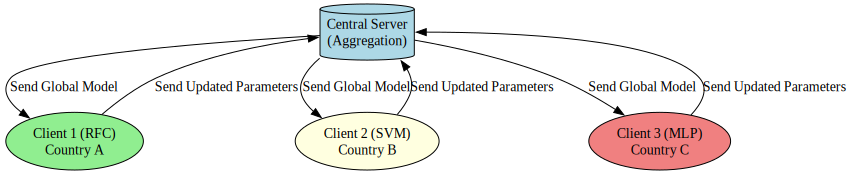

In [22]:
from graphviz import Digraph

# Create a directed graph
fl_graph = Digraph("Federated_Learning", format="png")

# Server node
fl_graph.node("Server", shape="cylinder", style="filled", fillcolor="lightblue", label="Central Server\n(Aggregation)")

# Client nodes
fl_graph.node("Client1", shape="ellipse", style="filled", fillcolor="lightgreen", label="Client 1 (RFC)\nCountry A")
fl_graph.node("Client2", shape="ellipse", style="filled", fillcolor="lightyellow", label="Client 2 (SVM)\nCountry B")
fl_graph.node("Client3", shape="ellipse", style="filled", fillcolor="lightcoral", label="Client 3 (MLP)\nCountry C")

# Connections (Training and Aggregation Flow)
fl_graph.edge("Server", "Client1", label="Send Global Model")
fl_graph.edge("Server", "Client2", label="Send Global Model")
fl_graph.edge("Server", "Client3", label="Send Global Model")

fl_graph.edge("Client1", "Server", label="Send Updated Parameters")
fl_graph.edge("Client2", "Server", label="Send Updated Parameters")
fl_graph.edge("Client3", "Server", label="Send Updated Parameters")

# Render and display the graph
fl_graph.render("federated_learning_process", view=True)
from IPython.display import display
display(fl_graph)

## Simulated Data For India & the USA

In [26]:
import pandas as pd
import numpy as np


# Load the Turkey dataset
file_path = "data/modis_2010_Turkey.csv"
df_turkey = pd.read_csv(file_path)

# Display basic information and first few rows
df_turkey.info(), df_turkey.head()
# Display first few columns to understand the structure
df_turkey.iloc[:, :15].head()
# Define bounding box coordinates for India and USA
india_bounds = {"lat_min": 8.0, "lat_max": 37.0, "lon_min": 68.0, "lon_max": 97.0}
usa_bounds = {"lat_min": 24.0, "lat_max": 49.0, "lon_min": -125.0, "lon_max": -67.0}

# Function to generate simulated coordinates within bounds
def generate_coordinates(df, lat_min, lat_max, lon_min, lon_max):
    df["latitude"] = np.random.uniform(lat_min, lat_max, len(df))
    df["longitude"] = np.random.uniform(lon_min, lon_max, len(df))
    return df

# Create simulated India and USA datasets
df_india = generate_coordinates(df_turkey.copy(), **india_bounds)
df_usa = generate_coordinates(df_turkey.copy(), **usa_bounds)

# Save the simulated datasets
india_path = "data/modis_2010_India.csv"
usa_path = "data/modis_2010_USA.csv"
df_india.to_csv(india_path, index=False)
df_usa.to_csv(usa_path, index=False)

india_path, usa_path


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13653 entries, 0 to 13652
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    13653 non-null  float64
 1   longitude   13653 non-null  float64
 2   brightness  13653 non-null  float64
 3   scan        13653 non-null  float64
 4   track       13653 non-null  float64
 5   acq_date    13653 non-null  object 
 6   acq_time    13653 non-null  int64  
 7   satellite   13653 non-null  object 
 8   instrument  13653 non-null  object 
 9   confidence  13653 non-null  int64  
 10  version     13653 non-null  float64
 11  bright_t31  13653 non-null  float64
 12  frp         13653 non-null  float64
 13  daynight    13653 non-null  object 
 14  type        13653 non-null  int64  
dtypes: float64(8), int64(3), object(4)
memory usage: 1.6+ MB


('data/modis_2010_India.csv', 'data/modis_2010_USA.csv')

## Faulty Simulation

In [36]:
import pandas as pd
import numpy as np

# Load Turkey dataset
turkey_df = pd.read_csv("data/modis_2010_Turkey.csv")

# Define function to simulate data based on seasonal wildfire trends
def generate_simulated_fire_data(base_df, country, months, locations):
    df = base_df.copy()
    
    # Assign country
    df["country"] = country
    
    # Adjust fire dates to match seasonal trends
    df["acq_date"] = np.random.choice(pd.date_range("2010-01-01", "2010-12-31"), size=len(df))
    df = df[df["acq_date"].dt.month.isin(months)]  # Keep only fires in specified months
    
    # Randomly assign fire locations from given list
    df["location"] = np.random.choice(locations, size=len(df), replace=True)
    
    return df

# Define seasonal trends and locations
india_months = [2, 3, 4, 5]  # Feb to May
india_locations = ["Madhya Pradesh", "Chhattisgarh", "Odisha", "Jharkhand", "Andhra Pradesh"]

usa_months = [7, 8, 9, 10, 11]  # July to November
usa_locations = ["California", "Oregon", "Washington", "Arizona", "Nevada"]

# Generate datasets
india_df = generate_simulated_fire_data(turkey_df, "India", india_months, india_locations)
usa_df = generate_simulated_fire_data(turkey_df, "USA", usa_months, usa_locations)

# Save updated datasets
india_path = "data/modis_2010_India_updated.csv"
usa_path = "data/modis_2010_USA_updated.csv"

india_df.to_csv(india_path, index=False)
usa_df.to_csv(usa_path, index=False)

india_path, usa_path


('data/modis_2010_India_updated.csv', 'data/modis_2010_USA_updated.csv')

## Simulated India Dataset Analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13653 entries, 0 to 13652
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    13653 non-null  float64
 1   longitude   13653 non-null  float64
 2   brightness  13653 non-null  float64
 3   scan        13653 non-null  float64
 4   track       13653 non-null  float64
 5   acq_date    13653 non-null  object 
 6   acq_time    13653 non-null  int64  
 7   satellite   13653 non-null  object 
 8   instrument  13653 non-null  object 
 9   confidence  13653 non-null  int64  
 10  version     13653 non-null  float64
 11  bright_t31  13653 non-null  float64
 12  frp         13653 non-null  float64
 13  daynight    13653 non-null  object 
 14  type        13653 non-null  int64  
dtypes: float64(8), int64(3), object(4)
memory usage: 1.6+ MB
None
    latitude  longitude  brightness  scan  track    acq_date  acq_time  \
0  24.823844  80.458571       307.8   1.6    1.2  201

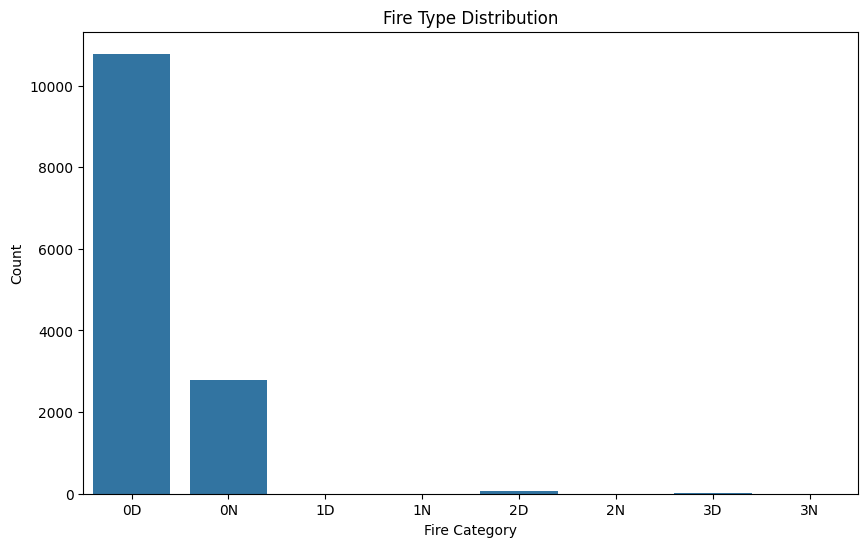

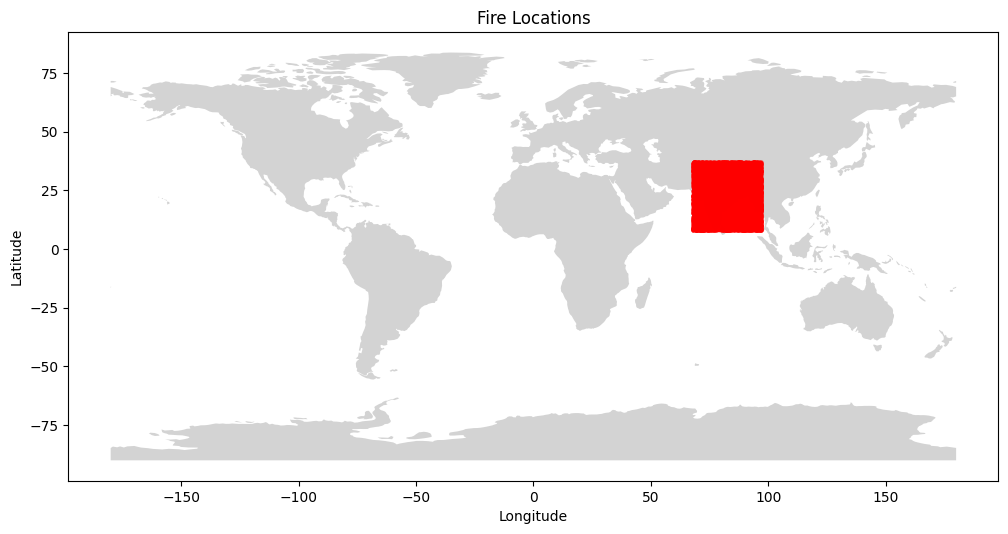

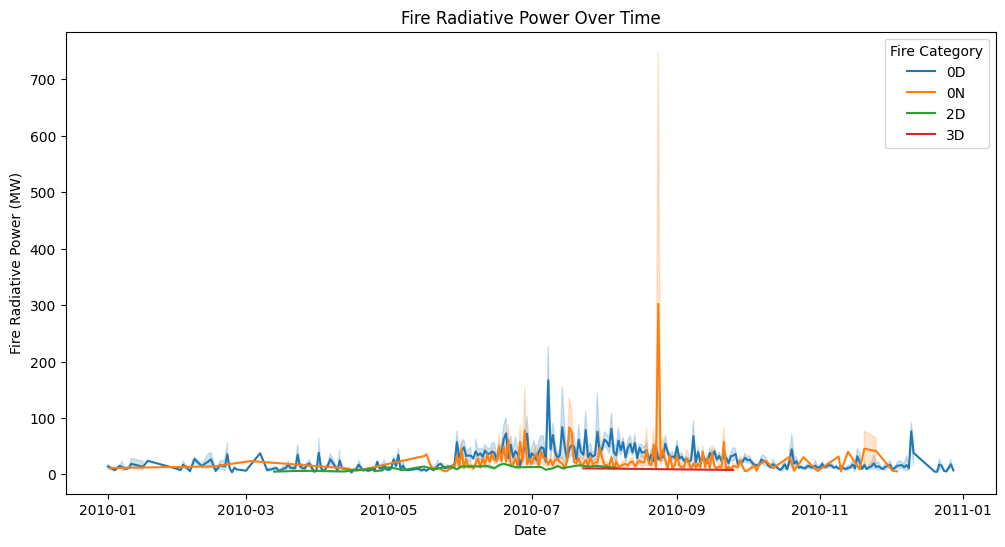

In [34]:
import pandas as pd

# Load dataset (modify path accordingly)
data_path = "data/modis_2010_India.csv"
df = pd.read_csv(data_path)

# General dataset information
print(df.info())

# Display first 5 rows
print(df.head())
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a new column for classification
df['fire_category'] = df['type'].astype(str) + df['daynight']

# Countplot of different fire types
plt.figure(figsize=(10,6))
sns.countplot(x='fire_category', data=df, order=['0D', '0N', '1D', '1N', '2D', '2N', '3D', '3N'])
plt.title('Fire Type Distribution')
plt.xlabel('Fire Category')
plt.ylabel('Count')
plt.show()

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geodatasets  # New package to get datasets

# Convert latitude and longitude to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Load the world map using geodatasets
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# Plot the map
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color='lightgrey')

# Plot fire locations
gdf.plot(ax=ax, markersize=5, color='red', alpha=0.5)
plt.title('Fire Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

df['acq_date'] = pd.to_datetime(df['acq_date'])

plt.figure(figsize=(12,6))
sns.lineplot(x='acq_date', y='frp', data=df, hue='fire_category')
plt.title('Fire Radiative Power Over Time')
plt.xlabel('Date')
plt.ylabel('Fire Radiative Power (MW)')
plt.legend(title='Fire Category')
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13653 entries, 0 to 13652
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    13653 non-null  float64
 1   longitude   13653 non-null  float64
 2   brightness  13653 non-null  float64
 3   scan        13653 non-null  float64
 4   track       13653 non-null  float64
 5   acq_date    13653 non-null  object 
 6   acq_time    13653 non-null  int64  
 7   satellite   13653 non-null  object 
 8   instrument  13653 non-null  object 
 9   confidence  13653 non-null  int64  
 10  version     13653 non-null  float64
 11  bright_t31  13653 non-null  float64
 12  frp         13653 non-null  float64
 13  daynight    13653 non-null  object 
 14  type        13653 non-null  int64  
dtypes: float64(8), int64(3), object(4)
memory usage: 1.6+ MB
None
    latitude   longitude  brightness  scan  track    acq_date  acq_time  \
0  41.221736  -89.494526       307.8   1.6    1.2  2

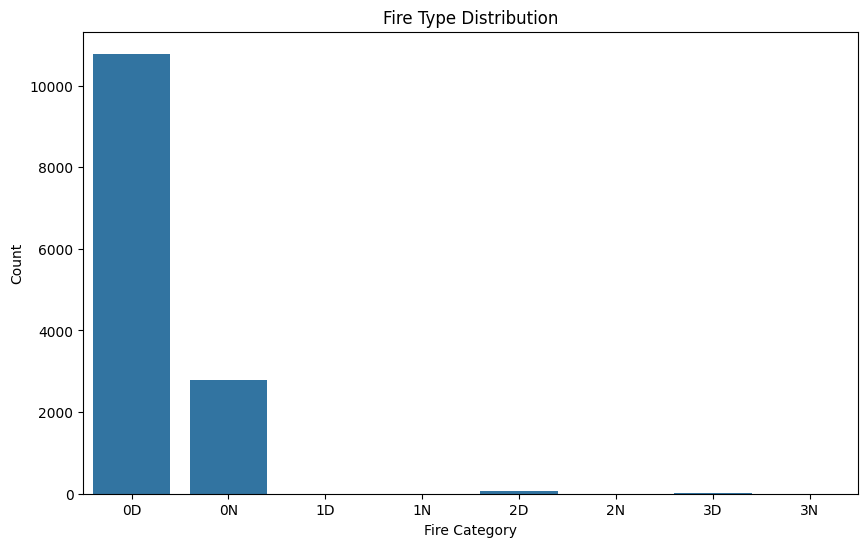

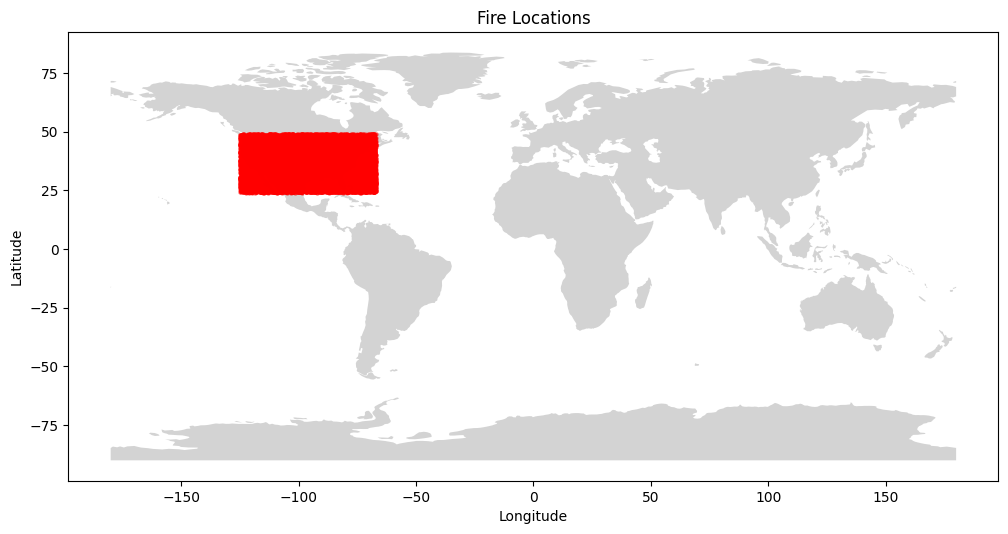

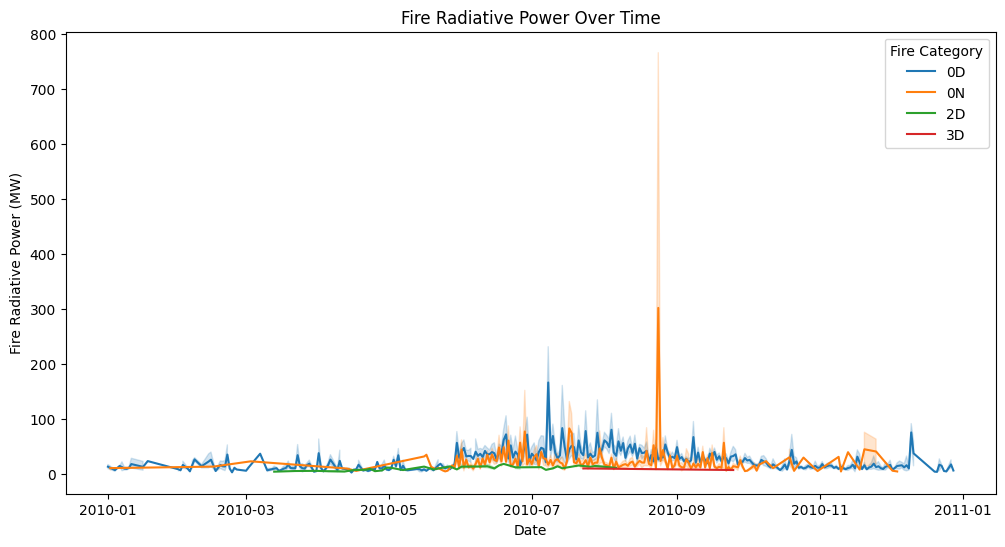

In [35]:
import pandas as pd

# Load dataset (modify path accordingly)
data_path = "data/modis_2010_USA.csv"
df = pd.read_csv(data_path)

# General dataset information
print(df.info())

# Display first 5 rows
print(df.head())
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a new column for classification
df['fire_category'] = df['type'].astype(str) + df['daynight']

# Countplot of different fire types
plt.figure(figsize=(10,6))
sns.countplot(x='fire_category', data=df, order=['0D', '0N', '1D', '1N', '2D', '2N', '3D', '3N'])
plt.title('Fire Type Distribution')
plt.xlabel('Fire Category')
plt.ylabel('Count')
plt.show()

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geodatasets  # New package to get datasets

# Convert latitude and longitude to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Load the world map using geodatasets
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# Plot the map
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color='lightgrey')

# Plot fire locations
gdf.plot(ax=ax, markersize=5, color='red', alpha=0.5)
plt.title('Fire Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

df['acq_date'] = pd.to_datetime(df['acq_date'])

plt.figure(figsize=(12,6))
sns.lineplot(x='acq_date', y='frp', data=df, hue='fire_category')
plt.title('Fire Radiative Power Over Time')
plt.xlabel('Date')
plt.ylabel('Fire Radiative Power (MW)')
plt.legend(title='Fire Category')
plt.show()

## Running three heterogeneous clients in Federated Learning
Federated learning uses FedAvg strategy. But it can consider only deeplearning models (parameters & bias), which is available only in MLP. So, for other two models they will not send model parameters to the server, rather they will send only accuracy. It can have some impact on overall accuracy of the learning. 